In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans, DBSCAN
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
import umap
from sklearn.metrics import silhouette_score
# from yellowbrick.cluster import KElbowVisualizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

In [2]:
# Load dataset
df = pd.read_csv('/Users/gargik/Downloads/US_Accidents_March23.csv')
df_OR = df[df["State"] == "OR"].copy()

Data-preprocessing

In [3]:
# Drop unnecessary columns
drop_cols = ['ID','Source','Description','Timezone','Country','Airport_Code','Weather_Timestamp','Wind_Chill(F)','Precipitation(in)','Amenity','Bump','Give_Way','No_Exit','Railway','Roundabout','Stop','Traffic_Calming','Turning_Loop','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight','State']
df_OR.drop(columns=drop_cols, inplace=True)

In [4]:
# Identify numerical and categorical columns
numerical_cols = df_OR.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df_OR.select_dtypes(exclude=['float64', 'int64']).columns

In [5]:
num_imputer = SimpleImputer(strategy='mean')
df_OR[numerical_cols] = num_imputer.fit_transform(df_OR[numerical_cols])

In [6]:
# Impute missing categorical values
cat_imputer = SimpleImputer(strategy='most_frequent')
df_OR[categorical_cols] = cat_imputer.fit_transform(df_OR[categorical_cols])

In [7]:
z_scaler = StandardScaler()
df_OR[numerical_cols] = z_scaler.fit_transform(df_OR[numerical_cols])
if 'Start_Time' in df_OR.columns:
    df_OR['Start_Time'] = pd.to_datetime(df_OR['Start_Time'], errors='coerce', format='%Y-%m-%d %H:%M:%S.%f')
    df_OR['Start_Year'] = df_OR['Start_Time'].dt.year
    df_OR['Start_Month'] = df_OR['Start_Time'].dt.month
    df_OR['Start_Day'] = df_OR['Start_Time'].dt.day
    df_OR['Start_Hour'] = df_OR['Start_Time'].dt.hour
    df_OR['Start_Minute'] = df_OR['Start_Time'].dt.minute
    df_OR['Start_Second'] = df_OR['Start_Time'].dt.second
    df_OR = df_OR.drop(columns=['Start_Time'])

In [8]:
if 'End_Time' in df_OR.columns:
    df_OR['End_Time'] = pd.to_datetime(df_OR['End_Time'], errors='coerce', format='%Y-%m-%d %H:%M:%S.%f')
    df_OR['End_Year'] = df_OR['End_Time'].dt.year
    df_OR['End_Month'] = df_OR['End_Time'].dt.month
    df_OR['End_Day'] = df_OR['End_Time'].dt.day
    df_OR['End_Hour'] = df_OR['End_Time'].dt.hour
    df_OR['End_Minute'] = df_OR['End_Time'].dt.minute
    df_OR['End_Second'] = df_OR['End_Time'].dt.second
    df_OR = df_OR.drop(columns=['End_Time'])

Dimension Reduction with UMAP

Silhouette Score: 0.336
               Model  Silhouette Score  Clusters
0  K-Means (Lat/Lng)          0.450000         5
1     K-Means (UMAP)          0.335577         4


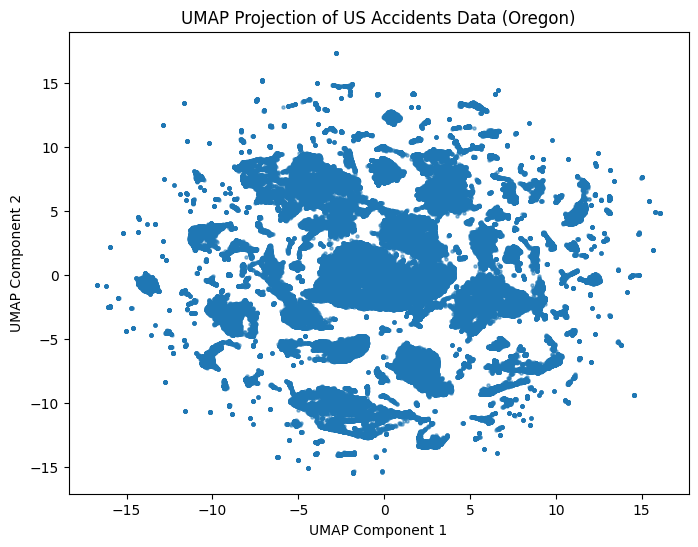

In [21]:
silhouette_avg = silhouette_score(df_umap[['UMAP1', 'UMAP2']], df_umap['Cluster'])
print(f"Silhouette Score: {silhouette_avg:.3f}")
# Summary Table of Clustering Performance
summary = pd.DataFrame({
    'Model': ['K-Means (Lat/Lng)', 'K-Means (UMAP)'],
    'Silhouette Score': [0.45, silhouette_avg],
    'Clusters': [5, optimal_k]
})
print(summary)
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=5, alpha=0.5)
plt.title("UMAP Projection of US Accidents Data (Oregon)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

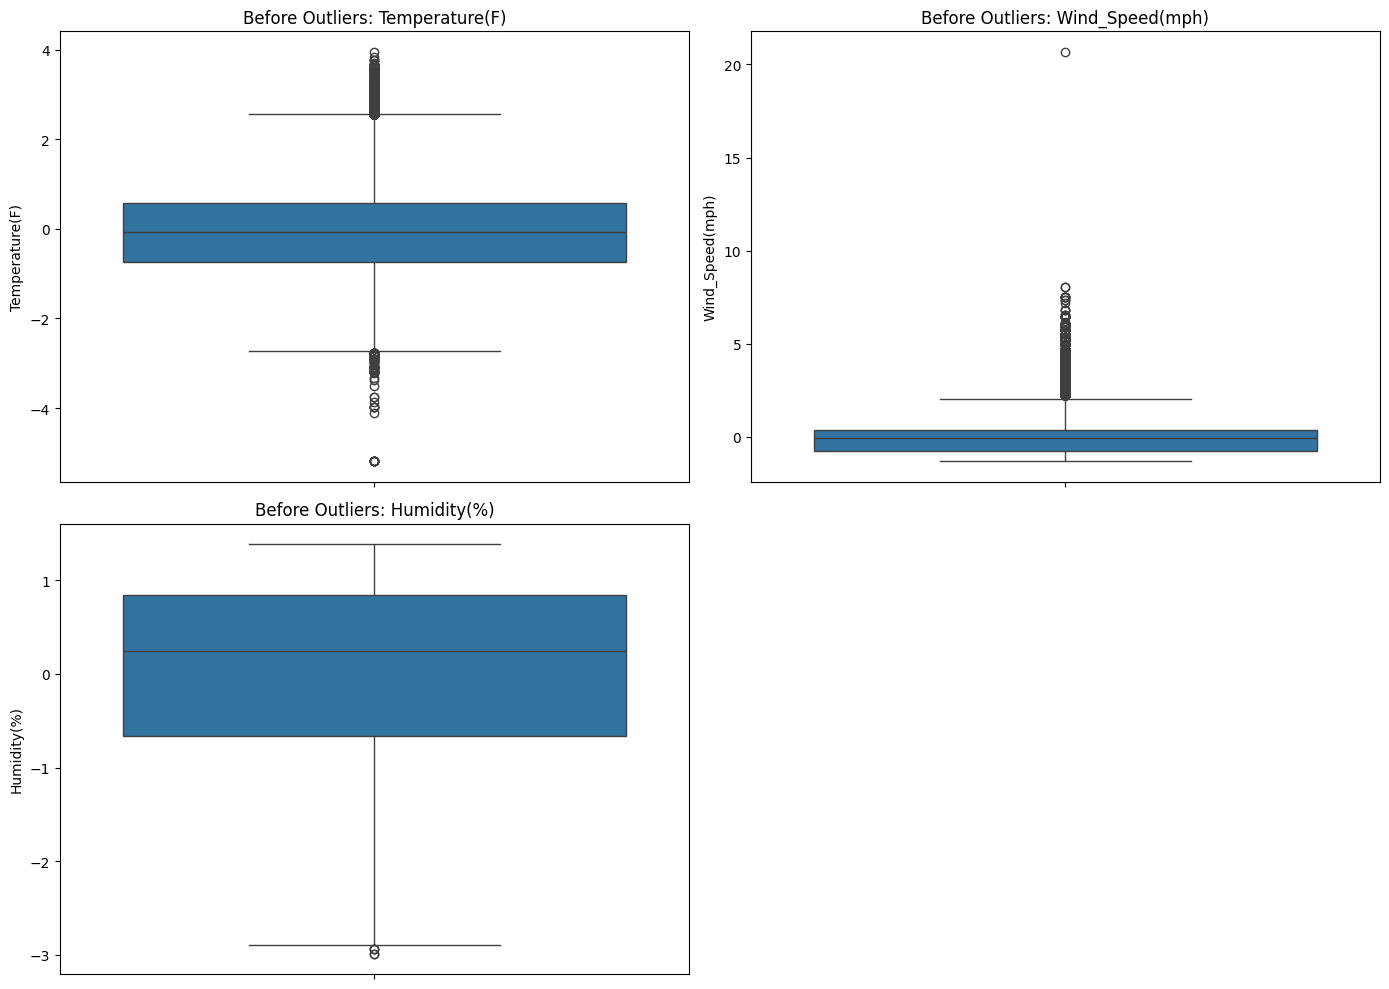

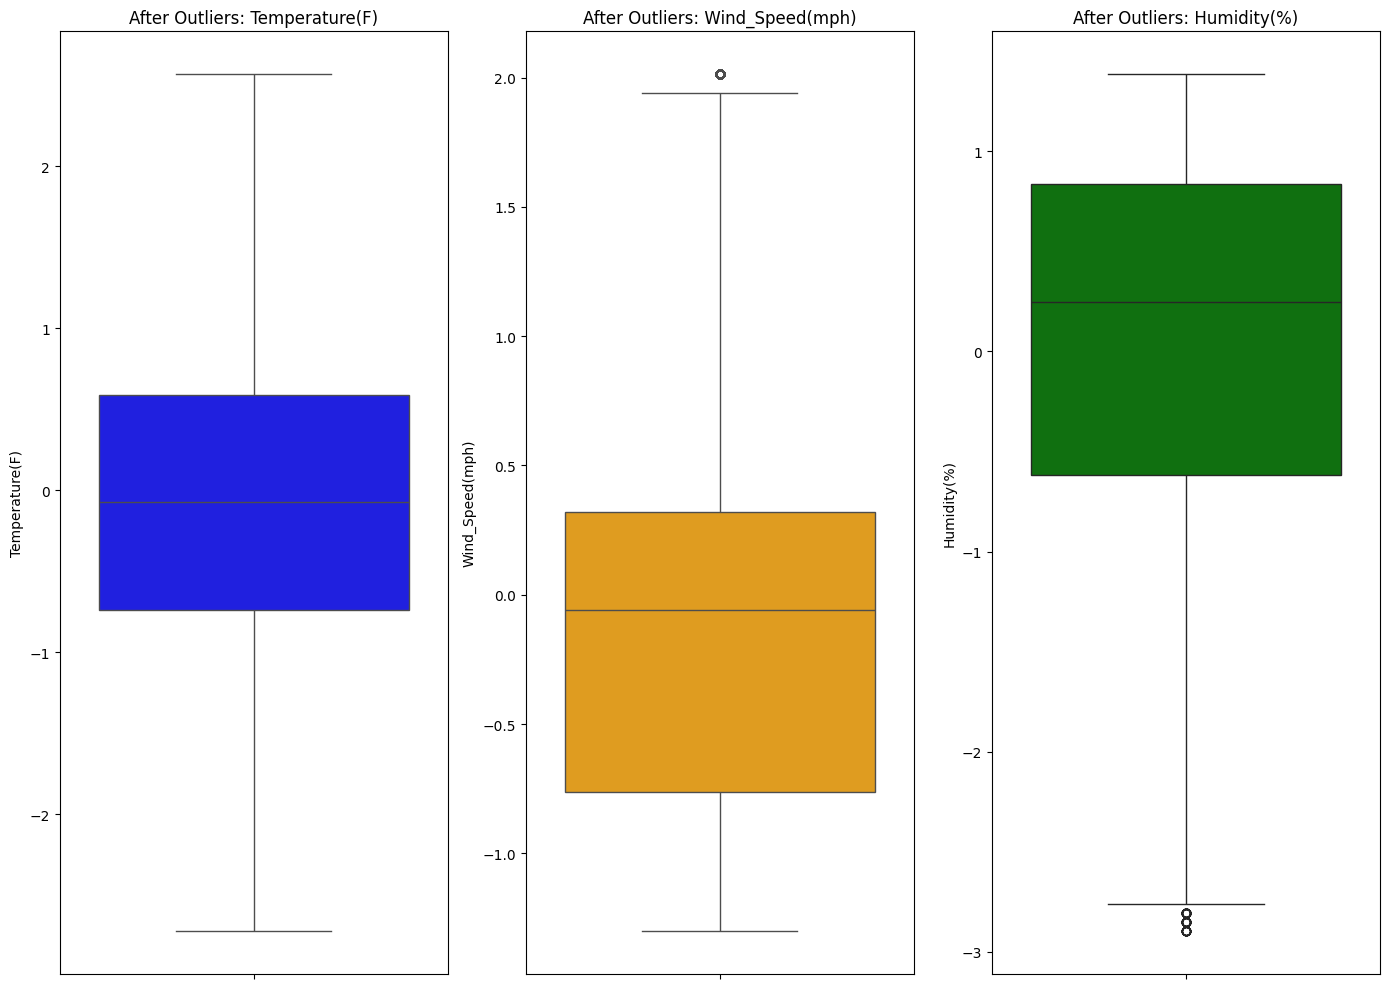

In [22]:
pd.set_option('display.max_rows', None)  # Show all rows (if applicable)
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Adjusts the width of the output
pd.set_option('display.max_colwidth', None) 

# Now calculate the statistical data
statistics = df_OR[numerical_cols].describe()
# Define selected columns for outlier removal
selected_outlier_cols = ['Temperature(F)', 'Wind_Speed(mph)', 'Humidity(%)']

# Calculate IQR to detect outliers
Q1 = df_OR[selected_outlier_cols].quantile(0.25)
Q3 = df_OR[selected_outlier_cols].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a copy of the original dataframe to remove outliers
df_cleaned = df_OR.copy()
for col in selected_outlier_cols:
    df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound[col]) & (df_cleaned[col] <= upper_bound[col])]

plt.figure(figsize=(14, 10))
for i, col in enumerate(selected_outlier_cols, 1):
    plt.subplot(2, 2, i)  
    sns.boxplot(y=df_OR[col])
    plt.title(f"Before Outliers: {col}")
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 10))
colors = ['blue', 'orange', 'green']  # Define the colors
for i, col in enumerate(selected_outlier_cols, 1):
    plt.subplot(1, len(selected_outlier_cols), i)  # Side-by-side boxplots
    sns.boxplot(y=df_cleaned[col], color=colors[i-1])  # Apply color to each boxplot
    plt.title(f"After Outliers: {col}")
plt.tight_layout()
plt.show()

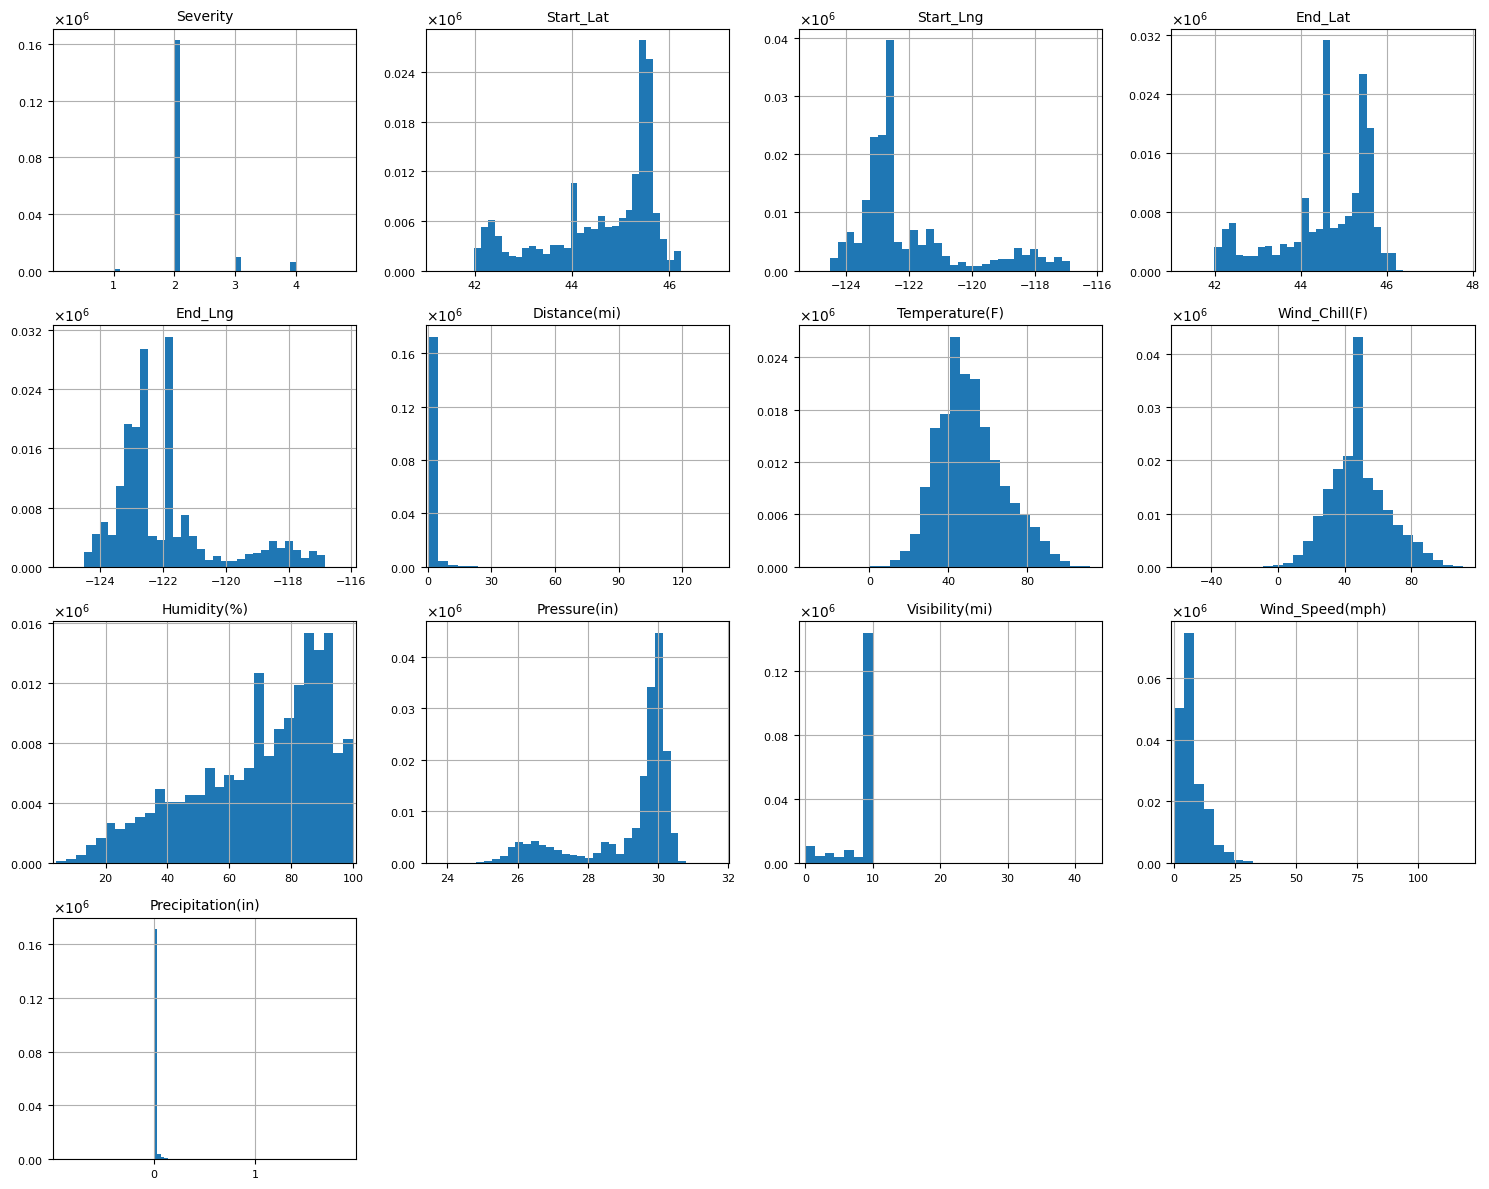

In [45]:
import matplotlib.ticker as ticker

df_OR1 = df[df["State"] == "OR"].copy()

# Select numeric columns
numeric_columns = [
    'Severity', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng',
    'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
    'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)'
]

# Impute missing values with the mean of each column
df_OR1[numeric_columns] = df_OR1[numeric_columns].fillna(df_OR1[numeric_columns].mean())

# Plot
fig, axs = plt.subplots(4, 4, figsize=(15, 12)) 
axs = axs.flatten()

# Plot histograms
for i, col in enumerate(numeric_columns):
    df_OR1[col].hist(bins=30, ax=axs[i])
    axs[i].set_title(col, fontsize=10)

    # Format y-axis to use 1e6 style (math text/scientific)
    y_formatter = ticker.ScalarFormatter(useMathText=True)
    y_formatter.set_scientific(True)
    y_formatter.set_powerlimits((6, 6))
    axs[i].yaxis.set_major_formatter(y_formatter)

    # Format x-axis to show plain numbers
    axs[i].xaxis.set_major_formatter(ticker.ScalarFormatter())
    axs[i].ticklabel_format(axis='x', style='plain')
    axs[i].tick_params(axis='x', labelsize=8)
    axs[i].tick_params(axis='y', labelsize=8)
    axs[i].set_xlim(df_OR1[col].min() - 1, df_OR1[col].max() + 1)  # Adjust range based on data

    axs[i].xaxis.set_major_locator(ticker.MaxNLocator(integer=True, prune='both', nbins=5))  # Reduce x-axis ticks
    axs[i].yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
# Hide any unused subplots
for j in range(len(numeric_columns), 16):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


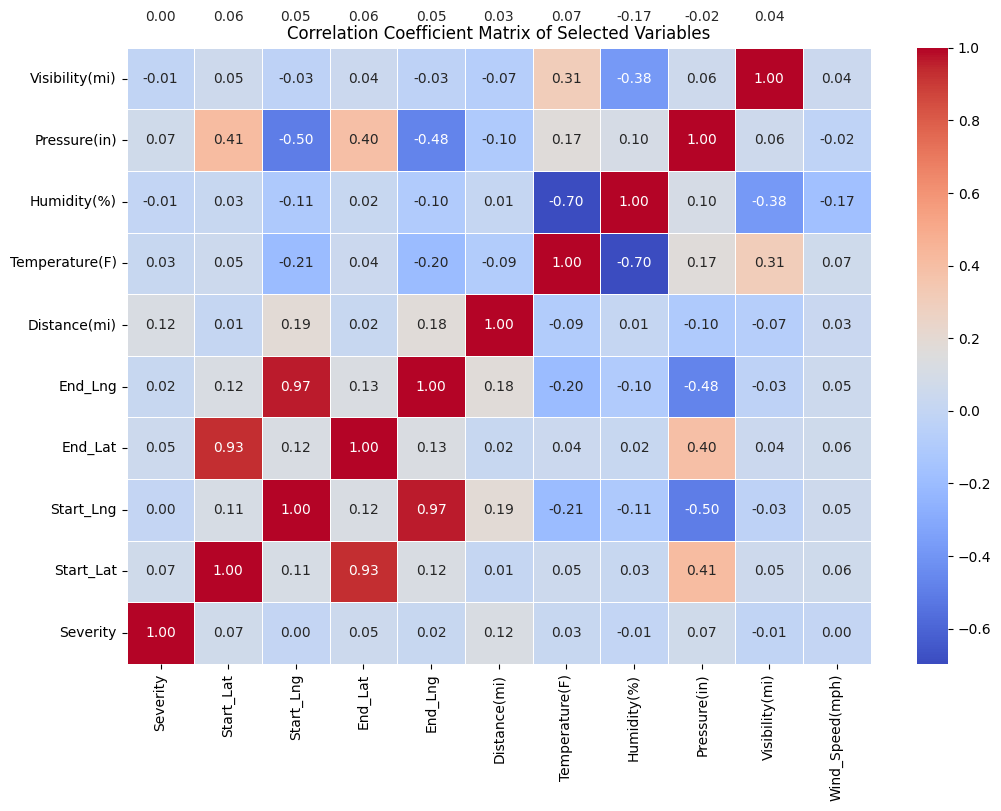

In [51]:
selected_vars = numerical_cols  # Selecting first 15 numerical variables
correlation_matrix = df_OR[selected_vars].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Coefficient Matrix of Selected Variables")
plt.ylim(0, 10)
plt.show()

/var/folders/t9/c_h8p22d4bl6k3wxgzphdyr80000gn/T/ipykernel_35410/3951834427.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accidents_count['Weather_Category'], y=accidents_count['Accident Count'], palette=['blue', 'orange'])


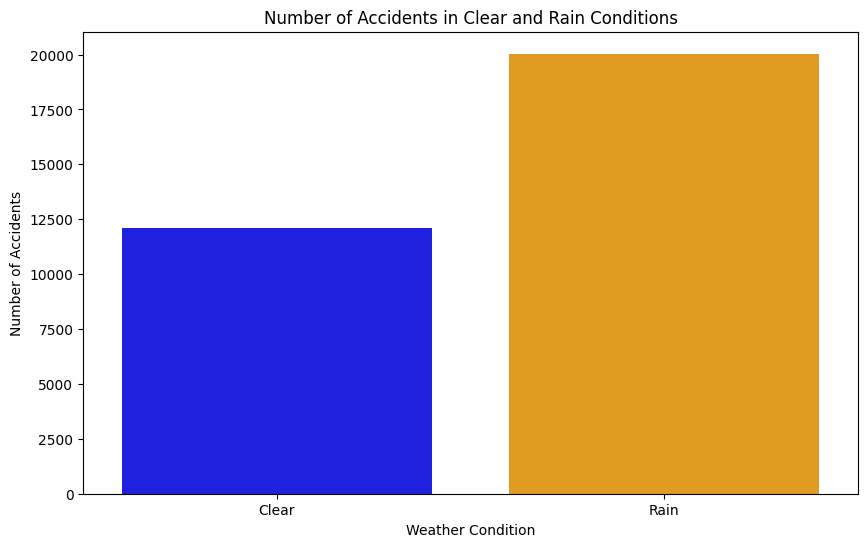

In [55]:
df_OR1 = df[df["State"] == "OR"].copy()

# Drop unnecessary columns
drop_cols = ['ID','Source','Description','Timezone','Country','Airport_Code','Weather_Timestamp','Wind_Chill(F)','Precipitation(in)','Amenity','Bump','Give_Way','No_Exit','Railway','Roundabout','Stop','Traffic_Calming','Turning_Loop','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight']
df_OR1.drop(columns=drop_cols, inplace=True)
df_OR1['Weather_Condition'] = df_OR1['Weather_Condition'].astype(str).fillna('Unknown')

# Create a 'Weather_Category' column based on the 'Weather_Condition' column
df_OR1['Weather_Category'] = df_OR1['Weather_Condition'].apply(
    lambda x: 'Clear' if 'Clear' in x else ('Rain' if 'Rain' in x else 'Other')
)

# Drop rows where 'Weather_Category' is None or 'Other'
df_OR1 = df_OR1[df_OR1['Weather_Category'].isin(['Clear', 'Rain'])]

# Count accidents by weather category
accidents_count = df_OR1.groupby('Weather_Category').size().reset_index(name='Accident Count')

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x=accidents_count['Weather_Category'], y=accidents_count['Accident Count'], palette=['blue', 'orange'])
plt.xlabel("Weather Condition")
plt.ylabel("Number of Accidents")
plt.title("Number of Accidents in Clear and Rain Conditions")
plt.show()


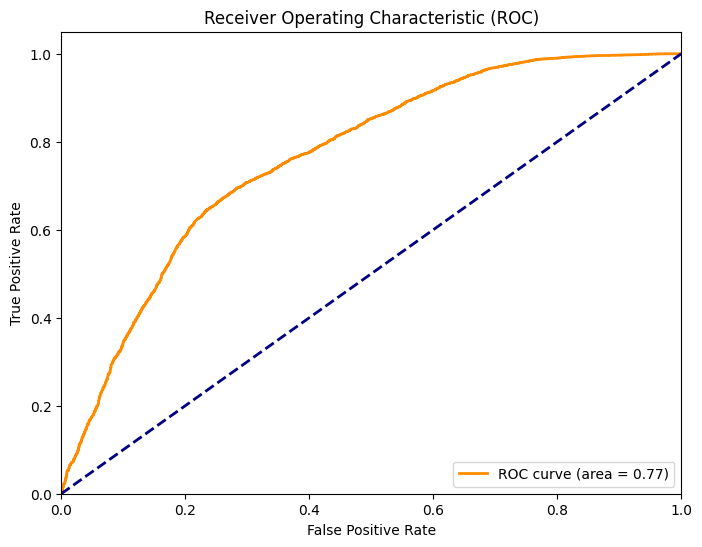

In [68]:
df_OR2 = df[df["State"] == "OR"].copy()

# Drop unnecessary columns
drop_cols = ['ID','Source','Description','Timezone','Country','Airport_Code','Weather_Timestamp','Wind_Chill(F)','Precipitation(in)','Amenity','Bump','Give_Way','No_Exit','Railway','Roundabout','Stop','Traffic_Calming','Turning_Loop','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight','State']
df_OR2.drop(columns=drop_cols, inplace=True)

# Identify numerical and categorical columns
numerical_cols = df_OR2.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df_OR2.select_dtypes(exclude=['float64', 'int64']).columns

num_imputer = SimpleImputer(strategy='mean')
df_OR2[numerical_cols] = num_imputer.fit_transform(df_OR2[numerical_cols])

# Impute missing categorical values
cat_imputer = SimpleImputer(strategy='most_frequent')
df_OR2[categorical_cols] = cat_imputer.fit_transform(df_OR2[categorical_cols])

z_scaler = StandardScaler()
df_OR2[numerical_cols] = z_scaler.fit_transform(df_OR2[numerical_cols])
if 'Start_Time' in df_OR2.columns:
    df_OR2['Start_Time'] = pd.to_datetime(df_OR2['Start_Time'], errors='coerce', format='%Y-%m-%d %H:%M:%S.%f')
    df_OR2['Start_Year'] = df_OR2['Start_Time'].dt.year
    df_OR2['Start_Month'] = df_OR2['Start_Time'].dt.month
    df_OR2['Start_Day'] = df_OR2['Start_Time'].dt.day
    df_OR2['Start_Hour'] = df_OR2['Start_Time'].dt.hour
    df_OR2['Start_Minute'] = df_OR2['Start_Time'].dt.minute
    df_OR2['Start_Second'] = df_OR2['Start_Time'].dt.second
    df_OR2 = df_OR2.drop(columns=['Start_Time'])

if 'End_Time' in df_OR2.columns:
    df_OR2['End_Time'] = pd.to_datetime(df_OR2['End_Time'], errors='coerce', format='%Y-%m-%d %H:%M:%S.%f')
    df_OR2['End_Year'] = df_OR2['End_Time'].dt.year
    df_OR2['End_Month'] = df_OR2['End_Time'].dt.month
    df_OR2['End_Day'] = df_OR2['End_Time'].dt.day
    df_OR2['End_Hour'] = df_OR2['End_Time'].dt.hour
    df_OR2['End_Minute'] = df_OR2['End_Time'].dt.minute
    df_OR2['End_Second'] = df_OR2['End_Time'].dt.second
    df_OR2 = df_OR2.drop(columns=['End_Time'])

df_OR_encoded = pd.get_dummies(df_OR2, columns=['City', 'Street','County','Zipcode','Wind_Direction','Sunrise_Sunset','Weather_Condition'], drop_first=True)
df_OR2 = df_OR_encoded
df_OR2['Severity_Binary'] = df_OR2['Severity'].apply(lambda x: 1 if x < 0 else 0)

X = df_OR2.drop(columns=['Severity', 'Severity_Binary'])  # Drop old column
y = df_OR2['Severity_Binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest model
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42)
#  Train the Random Forest model
rf_model.fit(X_train, y_train)

#  Predict on the test set
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1] 


# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

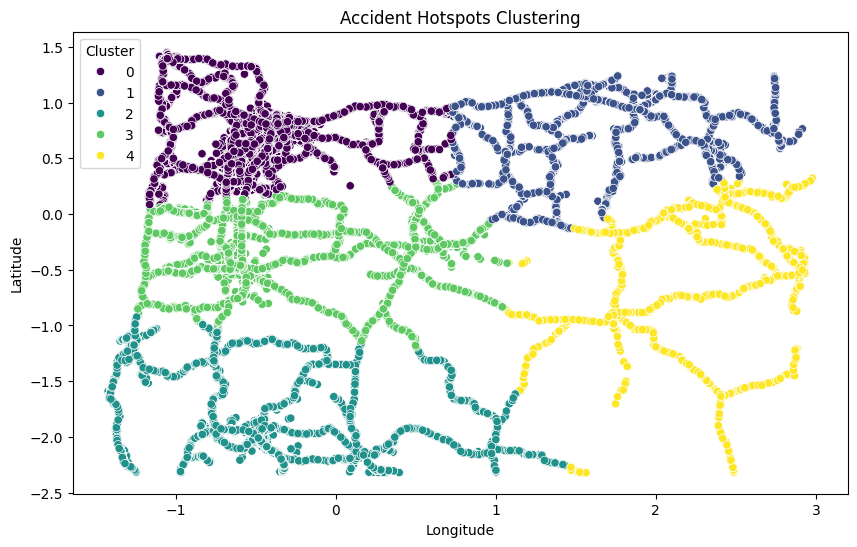

In [69]:
df_scaled = z_scaler.fit_transform(df_OR[['Start_Lat', 'Start_Lng']])

kmeans = KMeans(n_clusters=5, random_state=42)
df_OR['Cluster'] = kmeans.fit_predict(df_scaled)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_OR['Start_Lng'], y=df_OR['Start_Lat'], hue=df_OR['Cluster'], palette='viridis')
plt.title('Accident Hotspots Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

DATA EXPLORATION AND VISUALIZATION

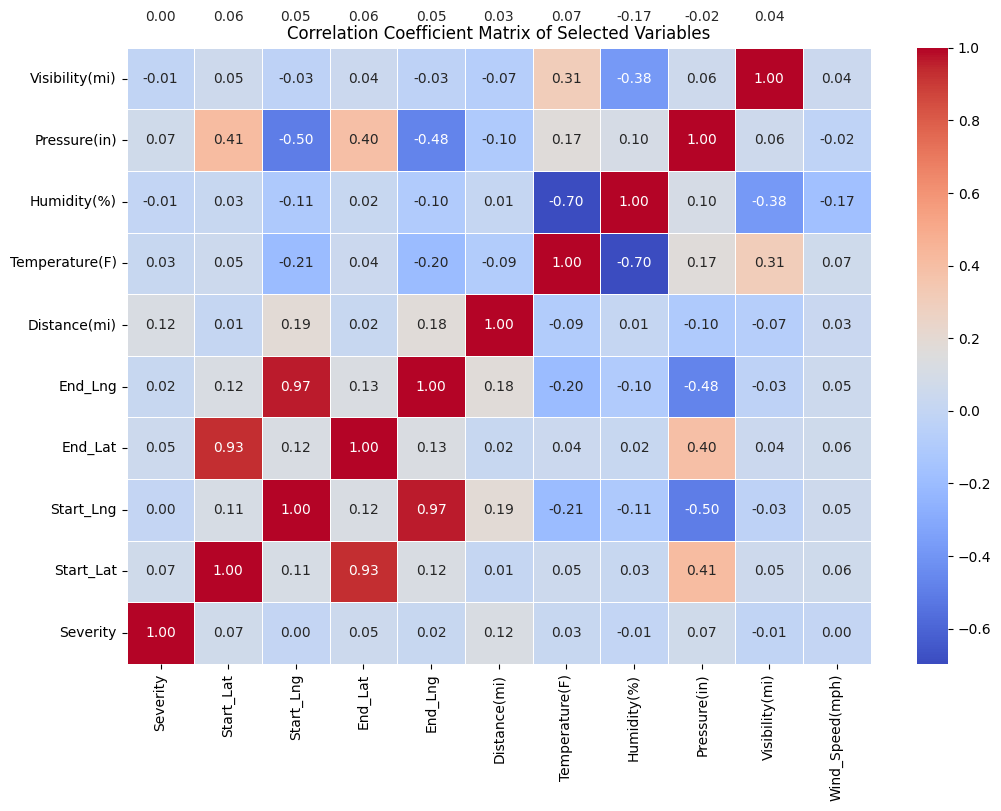

C:\Users\csk23\AppData\Local\Temp\ipykernel_43228\910847112.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_OR['Weather_Category'], y=df_OR['Severity'], palette=['blue', 'orange'])


<Figure size 1200x600 with 0 Axes>

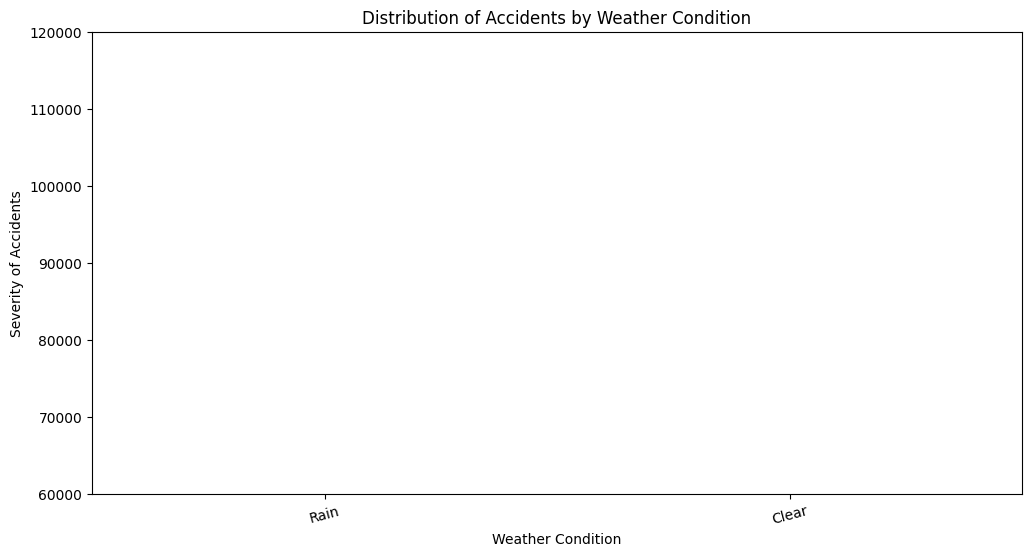

C:\Users\csk23\AppData\Local\Temp\ipykernel_43228\910847112.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accidents_count['Weather_Category'], y=accidents_count['Accident Count'], palette=['blue', 'orange'])


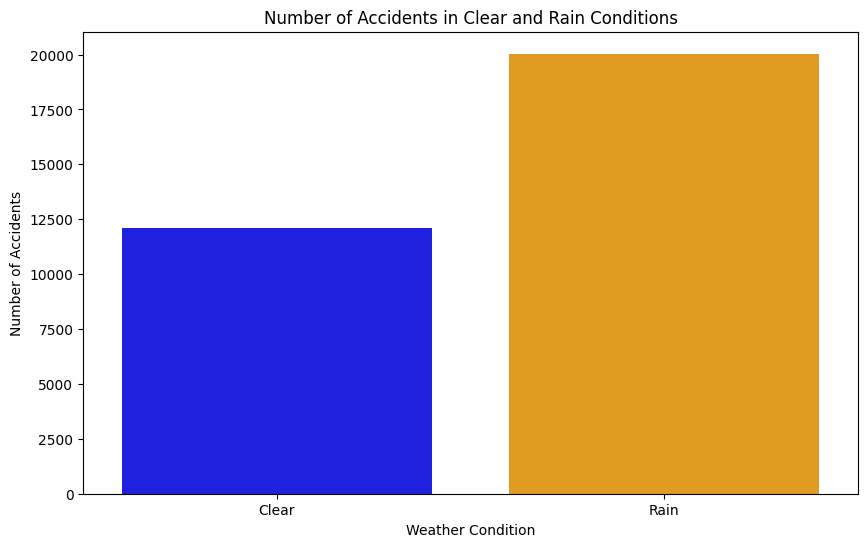

NameError: name 'df_cleaned' is not defined

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns

# Load dataset
df = pd.read_csv('C:/Users/csk23/Documents/U.S/Northeastern/2nd SEM/DATA MINING/US_Accidents_March23.csv')
df_OR = df[df["State"] == "OR"].copy()

# Drop unnecessary columns
drop_cols = ['ID','Source','Description','Timezone','Country','Airport_Code','Weather_Timestamp','Wind_Chill(F)','Precipitation(in)','Amenity','Bump','Give_Way','No_Exit','Railway','Roundabout','Stop','Traffic_Calming','Turning_Loop','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight']
df_OR.drop(columns=drop_cols, inplace=True)

# Identify numerical and categorical columns
numerical_cols = df_OR.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df_OR.select_dtypes(exclude=['float64', 'int64']).columns

num_imputer = SimpleImputer(strategy='mean')
df_OR[numerical_cols] = num_imputer.fit_transform(df_OR[numerical_cols])

# Impute missing categorical values
cat_imputer = SimpleImputer(strategy='most_frequent')
df_OR[categorical_cols] = cat_imputer.fit_transform(df_OR[categorical_cols])

z_scaler = StandardScaler()
df_OR[numerical_cols] = z_scaler.fit_transform(df_OR[numerical_cols])

pd.set_option('display.max_rows', None)  # Show all rows (if applicable)
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Adjusts the width of the output
pd.set_option('display.max_colwidth', None)  # Avoid truncation of column values

# Generate heatmap for correlation matrix of 15 selected variables
selected_vars = numerical_cols  # Selecting first 15 numerical variables
correlation_matrix = df_OR[selected_vars].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Coefficient Matrix of Selected Variables")
plt.ylim(0, 10)
plt.show()

# Generate side-by-side boxplot for day vs. night accident distribution

df_OR['Start_Time'] = pd.to_datetime(df_OR['Start_Time'], errors='coerce')
df_OR['Hour'] = df_OR['Start_Time'].dt.hour

df_OR['Weather_Condition'] = df_OR['Weather_Condition'].astype(str).fillna('Unknown')
df_OR['Weather_Category'] = df_OR['Weather_Condition'].apply(lambda x: 'Clear' if 'Clear' in x else ('Rain' if 'Rain' in x else None))
df_OR = df_OR.dropna(subset=['Weather_Category'])

plt.figure(figsize=(12, 6))
accidents_count = df_OR.groupby('Weather_Category').size().reset_index(name='Accident Count')
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_OR['Weather_Category'], y=df_OR['Severity'], palette=['blue', 'orange'])
plt.xticks(rotation=15)
plt.xlabel("Weather Condition")
plt.ylabel("Severity of Accidents")
plt.title("Distribution of Accidents by Weather Condition")
plt.ylim(60000, 120000)
plt.show()

# Construct bar graph for number of accidents in Clear and Rain
plt.figure(figsize=(10, 6))
sns.barplot(x=accidents_count['Weather_Category'], y=accidents_count['Accident Count'], palette=['blue', 'orange'])
plt.xlabel("Weather Condition")
plt.ylabel("Number of Accidents")
plt.title("Number of Accidents in Clear and Rain Conditions")
plt.show()



# Now calculate the statistical data
statistics = df_OR[numerical_cols].describe()

# Define selected columns for outlier removal
selected_outlier_cols = ['Temperature(F)', 'Wind_Speed(mph)', 'Humidity(%)']

# Calculate IQR to detect outliers
Q1 = df_OR[selected_outlier_cols].quantile(0.25)
Q3 = df_OR[selected_outlier_cols].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a copy of the original dataframe to remove outliers
df_cleaned = df_OR.copy()
for col in selected_outlier_cols:
    df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound[col]) & (df_cleaned[col] <= upper_bound[col])]

plt.figure(figsize=(14, 10))
for i, col in enumerate(selected_outlier_cols, 1):
    plt.subplot(2, 2, i)  
    sns.boxplot(y=df_OR[col])
    plt.title(f"Before Outliers: {col}")
plt.tight_layout()
plt.ylim(60000, 120000)
plt.show()

plt.figure(figsize=(14, 10))
colors = ['blue', 'orange', 'green']  # Define the colors
for i, col in enumerate(selected_outlier_cols, 1):
    plt.subplot(1, len(selected_outlier_cols), i)  # Side-by-side boxplots
    sns.boxplot(y=df_cleaned[col], color=colors[i-1])  # Apply color to each boxplot
    plt.title(f"After Outliers: {col}")
plt.tight_layout()
plt.ylim(60000, 120000)
plt.show()

# Extract and analyze accidents per decade
df["Start_Time"] = pd.to_datetime(df["Start_Time"], errors="coerce")  # Convert to datetime format
df["Year"] = df["Start_Time"].dt.year  # Grouping years into decades

# Count accidents per decade
accidents_per_year = df["Year"].value_counts().sort_index()

# Extract accidents by severity category
accidents_by_severity = df.groupby(["Year", "Severity"]).size().unstack(fill_value=0)

# Plot the line graph with two different categories
plt.figure(figsize=(12, 6))
plt.plot(accidents_by_severity.index, accidents_by_severity[1], marker='o', linestyle='-', color='r', label='Minor Accidents (Severity 1)')
plt.plot(accidents_by_severity.index, accidents_by_severity[4], marker='s', linestyle='-', color='g', label='Severe Accidents (Severity 4)')
plt.figure(figsize=(12, 6))
plt.plot(accidents_per_year.index, accidents_per_year.values, marker='o', linestyle='-', color='b', label='Total Accidents')
plt.xlabel("Year")
plt.ylabel("Actual Number of Accidents")
plt.title("Number of Accidents per Year by Category")
plt.legend(); plt.grid(True)
plt.ylim(60000, 120000)
plt.show()


In [5]:
# Save preprocessed data to an Excel file
df_OR.to_excel('C:/Users/csk23/Documents/U.S/Northeastern/2nd SEM/DATA MINING/Preprocessed_US_Accidents.xlsx', index=False)
print('Preprocessed data saved as Preprocessed_US_Accidents.xlsx')

Preprocessed data saved as Preprocessed_US_Accidents.xlsx


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns

# Load dataset
df = pd.read_csv('C:/Users/csk23/Documents/U.S/Northeastern/2nd SEM/DATA MINING/US_Accidents_March23.csv')
df_OR = df[df["State"] == "OR"].copy()

# Drop unnecessary columns
drop_cols = ['ID','Source','Description','Timezone','Country','Airport_Code','Weather_Timestamp','Wind_Chill(F)','Precipitation(in)','Amenity','Bump','Give_Way','No_Exit','Railway','Roundabout','Stop','Traffic_Calming','Turning_Loop','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight']
df_OR.drop(columns=drop_cols, inplace=True)

# Identify numerical and categorical columns
numerical_cols = df_OR.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df_OR.select_dtypes(exclude=['float64', 'int64']).columns

num_imputer = SimpleImputer(strategy='mean')
df_OR[numerical_cols] = num_imputer.fit_transform(df_OR[numerical_cols])

# Impute missing categorical values
cat_imputer = SimpleImputer(strategy='most_frequent')
df_OR[categorical_cols] = cat_imputer.fit_transform(df_OR[categorical_cols])

z_scaler = StandardScaler()
df_OR[numerical_cols] = z_scaler.fit_transform(df_OR[numerical_cols])

pd.set_option('display.max_rows', None)  # Show all rows (if applicable)
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Adjusts the width of the output
pd.set_option('display.max_colwidth', None)  # Avoid truncation of column values

# Now calculate the statistical data
statistics = df_OR[numerical_cols].describe()

# Define selected columns for outlier removal
selected_outlier_cols = ['Temperature(F)', 'Wind_Speed(mph)', 'Humidity(%)']

# Calculate IQR to detect outliers
Q1 = df_OR[selected_outlier_cols].quantile(0.25)
Q3 = df_OR[selected_outlier_cols].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a copy of the original dataframe to remove outliers
df_cleaned = df_OR.copy()
for col in selected_outlier_cols:
    df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound[col]) & (df_cleaned[col] <= upper_bound[col])]


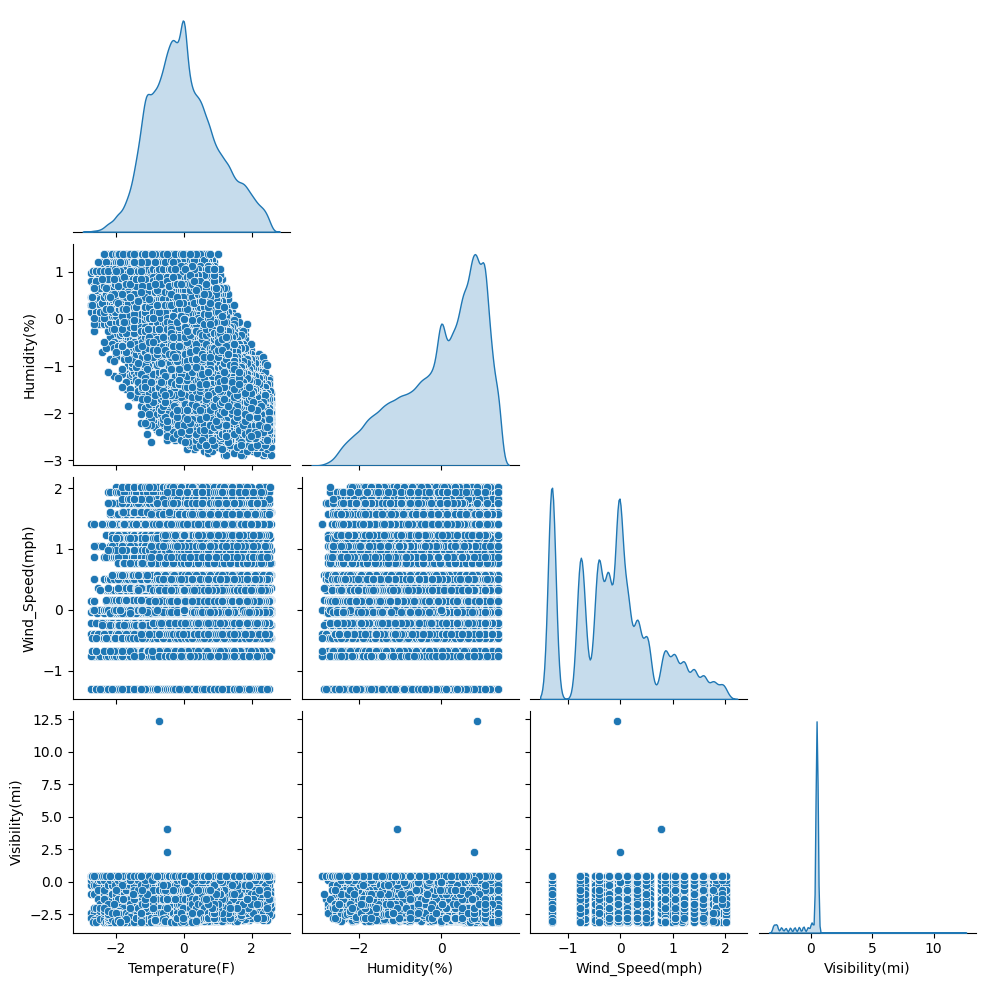

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical columns for multivariate analysis
selected_features = ['Temperature(F)', 'Humidity(%)', 'Wind_Speed(mph)', 'Visibility(mi)']

# Create a pairplot for multivariate visualization
sns.pairplot(df_cleaned[selected_features], diag_kind='kde', corner=True)

# Show the plot
plt.show()


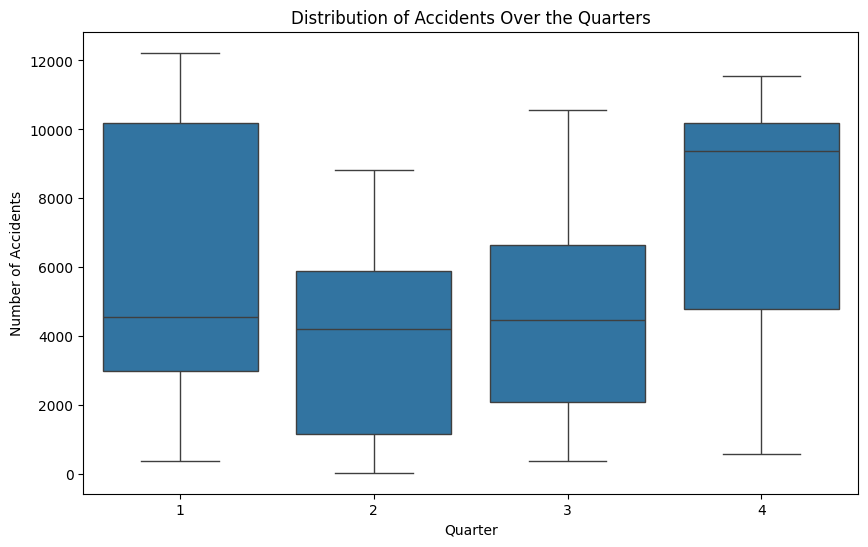

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'Start_Time' is in a valid datetime format
df_cleaned['Start_Time'] = pd.to_datetime(df_cleaned['Start_Time'], errors='coerce')

# Drop rows where conversion failed
df_cleaned = df_cleaned.dropna(subset=['Start_Time'])

# Extract the quarter information
df_cleaned['Quarter'] = df_cleaned['Start_Time'].dt.quarter

# Aggregate the number of accidents per quarter
quarterly_counts = df_cleaned.groupby(['Quarter', df_cleaned['Start_Time'].dt.year]).size().reset_index(name='Accident_Count')

# Create a side-by-side box plot for the distribution of accidents per quarter
plt.figure(figsize=(10, 6))
sns.boxplot(x='Quarter', y='Accident_Count', data=quarterly_counts)

# Set labels and title
plt.xlabel('Quarter')
plt.ylabel('Number of Accidents')
plt.title('Distribution of Accidents Over the Quarters')

# Show the plot
plt.show()


C:\Users\csk23\AppData\Local\Temp\ipykernel_43228\2681987013.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accident_Count', y='City', data=top_cities, palette='viridis')


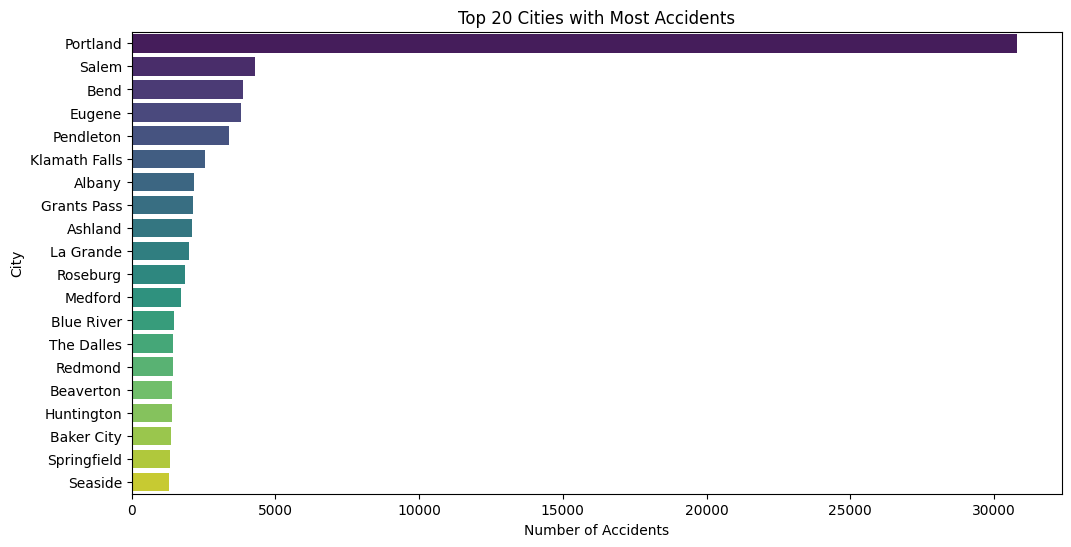

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of accidents per city
city_accidents = df_cleaned['City'].value_counts().reset_index()
city_accidents.columns = ['City', 'Accident_Count']

# Select top 20 cities with the most accidents for better visualization
top_cities = city_accidents.head(20)

# Create a bar plot for accidents per city
plt.figure(figsize=(12, 6))
sns.barplot(x='Accident_Count', y='City', data=top_cities, palette='viridis')

# Set labels and title
plt.xlabel('Number of Accidents')
plt.ylabel('City')
plt.title('Top 20 Cities with Most Accidents')

# Show the plot
plt.show()


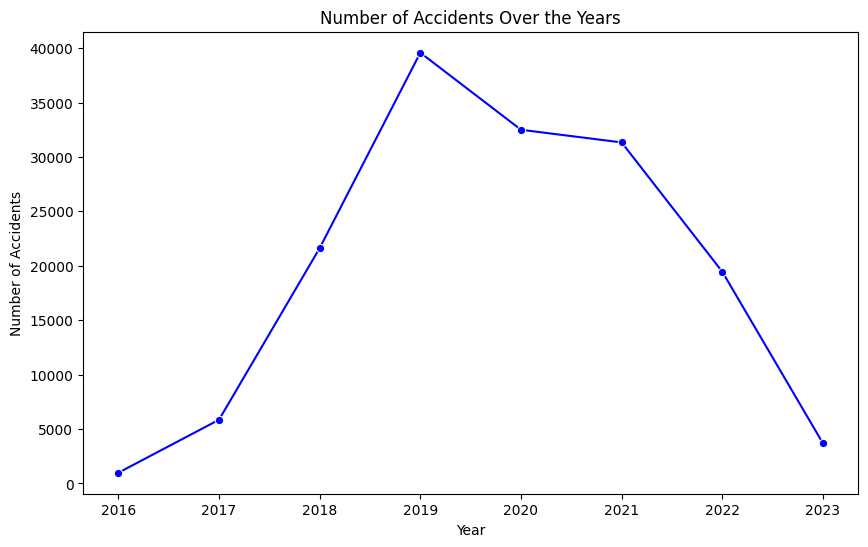

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Convert 'Start_Time' to datetime format
df_cleaned['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')

# Extract the year from 'Start_Time'
df_cleaned['Year'] = df_cleaned['Start_Time'].dt.year

# Count the number of accidents per year
yearly_accidents = df_cleaned['Year'].value_counts().reset_index()
yearly_accidents.columns = ['Year', 'Accident_Count']
yearly_accidents = yearly_accidents.sort_values('Year')

# Create a line plot for accidents over the years
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Accident_Count', data=yearly_accidents, marker='o', color='b')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.title('Number of Accidents Over the Years')

# Show the plot
plt.show()


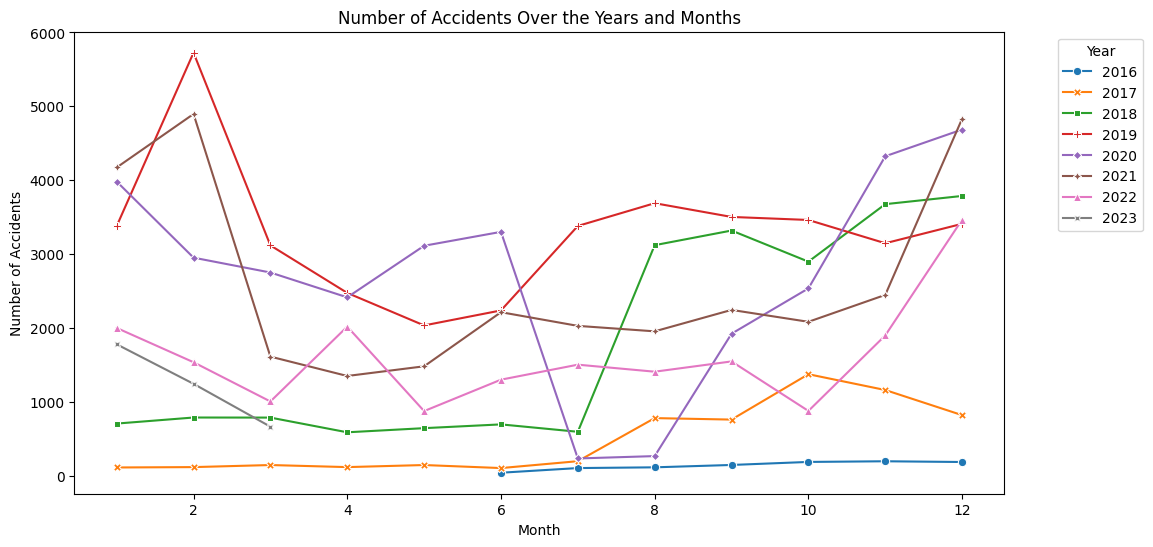

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Convert 'Start_Time' to datetime format
df_cleaned['Start_Time'] = pd.to_datetime(df_cleaned['Start_Time'], errors='coerce')

# Extract the year and month from 'Start_Time'
df_cleaned['Year'] = df_cleaned['Start_Time'].dt.year
df_cleaned['Month'] = df_cleaned['Start_Time'].dt.month

# Count the number of accidents per year and month
monthly_accidents = df_cleaned.groupby(['Year', 'Month']).size().reset_index(name='Accident_Count')

# Create a pivot table for visualization
monthly_pivot = monthly_accidents.pivot(index='Month', columns='Year', values='Accident_Count')

# Create a line plot for accidents over the years and months
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_pivot, markers=True, dashes=False)

# Set labels and title
plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.title('Number of Accidents Over the Years and Months')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


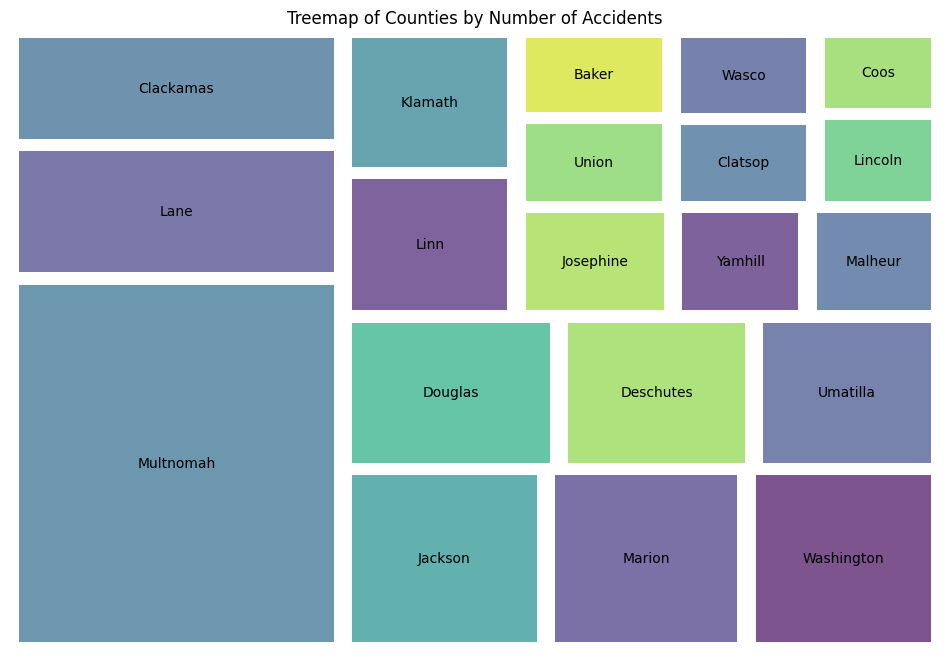

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import squarify


# Count the number of accidents per county
county_accidents = df_cleaned['County'].value_counts().reset_index()
county_accidents.columns = ['County', 'Accident_Count']

# Select top 20 counties with the most accidents for better visualization
top_counties = county_accidents.head(20)

# Create a treemap for accidents per county
plt.figure(figsize=(12, 8))
squarify.plot(sizes=top_counties['Accident_Count'], label=top_counties['County'], alpha=0.7, pad=True)

# Set labels and title
plt.title('Treemap of Counties by Number of Accidents')
plt.axis('off')

# Show the plot
plt.show()


DATA MINING MODELS

In [2]:
pip install pulp

   ---------------------------------------- 0.0/17.7 MB ? eta -:--:--
   ---------------- ----------------------- 7.1/17.7 MB 37.8 MB/s eta 0:00:01
   ----------------------------------- ---- 15.7/17.7 MB 39.7 MB/s eta 0:00:01
   ---------------------------------------- 17.7/17.7 MB 35.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [5]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


c:\Users\csk23\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\csk23\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\csk23\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\csk23\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1036

Selected Station Indices: [0, 3, 5, 7, 8]
Total Assignment Distance: 116.95 miles


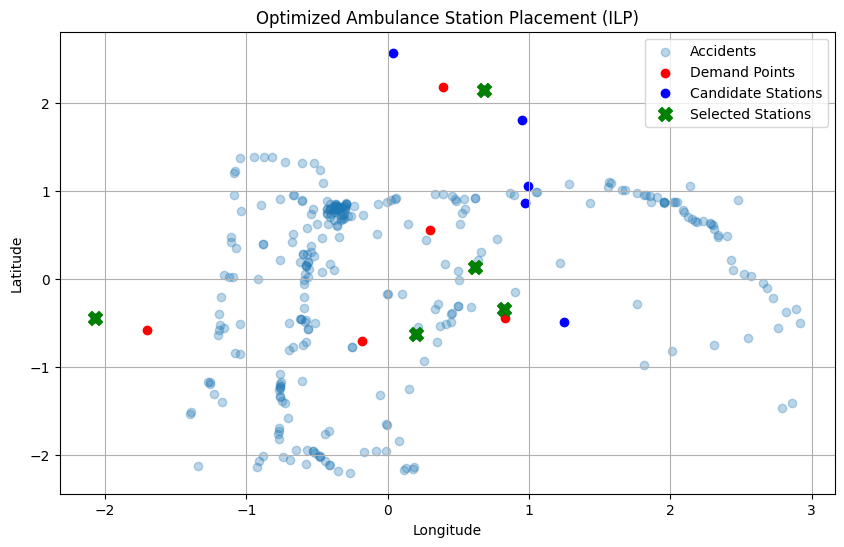

In [ ]:
#ILP
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpBinary, PULP_CBC_CMD
from geopy.distance import geodesic
import matplotlib.pyplot as plt

# Step 1: Load & sample geographic data
df = pd.read_excel("C:/Users/csk23/Documents/U.S/Northeastern/2nd SEM/DATA MINING/Preprocessed_US_Accidents.xlsx", usecols=["Start_Lat", "Start_Lng"])
df = df.dropna().sample(n=300, random_state=42)  # Sample 300 accident points for tractability

# Step 2: Cluster accident locations into demand zones (e.g., 5)
kmeans = KMeans(n_clusters=5, random_state=0)
df["Cluster"] = kmeans.fit_predict(df[["Start_Lat", "Start_Lng"]])
demand_points = kmeans.cluster_centers_

# Step 3: Define candidate station locations (e.g., 10 random accident locations)
station_indices = df.sample(n=10, random_state=1).index
station_locations = df.loc[station_indices, ["Start_Lat", "Start_Lng"]].values

# Step 4: Calculate distance matrix between demand points and candidate stations
distance_matrix = np.zeros((len(demand_points), len(station_locations)))
for i, dp in enumerate(demand_points):
    for j, sp in enumerate(station_locations):
        distance_matrix[i, j] = geodesic(dp, sp).miles

# Step 5: ILP model
model = LpProblem("Ambulance_Station_Optimization", LpMinimize)

# Binary variables: x[j] = 1 if station j is selected
x = LpVariable.dicts("Station", range(len(station_locations)), cat=LpBinary)

# Binary variables: y[i][j] = 1 if demand point i is covered by station j
y = LpVariable.dicts("Coverage", (range(len(demand_points)), range(len(station_locations))), cat=LpBinary)

# Objective: Minimize total distance from stations to demand points
model += lpSum(distance_matrix[i][j] * y[i][j] for i in range(len(demand_points)) for j in range(len(station_locations)))

# Constraint 1: Each demand point must be covered by at least one station
for i in range(len(demand_points)):
    model += lpSum(y[i][j] for j in range(len(station_locations))) >= 1

# Constraint 2: A demand point can only be assigned to an open station
for i in range(len(demand_points)):
    for j in range(len(station_locations)):
        model += y[i][j] <= x[j]

# Optional: limit number of stations to be opened (e.g., max 5)
model += lpSum(x[j] for j in range(len(station_locations))) <= 5

# Solve
model.solve(PULP_CBC_CMD(msg=1))

# Output selected station indices
selected_stations = [j for j in range(len(station_locations)) if x[j].varValue == 1]
print("Selected Station Indices:", selected_stations)

# Evaluate total distance
total_distance = sum(distance_matrix[i][j] * y[i][j].varValue
                     for i in range(len(demand_points)) for j in range(len(station_locations)))
print("Total Assignment Distance:", round(total_distance, 2), "miles")

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(df["Start_Lng"], df["Start_Lat"], alpha=0.3, label="Accidents")
plt.scatter(*zip(*demand_points), color="red", label="Demand Points")
plt.scatter(*zip(*station_locations), color="blue", label="Candidate Stations")
plt.scatter(*zip(*station_locations[selected_stations]), color="green", label="Selected Stations", marker="X", s=100)
plt.title("Optimized Ambulance Station Placement (ILP)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
import pandas as pd
from sklearn.cluster import KMeans
from pulp import *
from geopy.distance import geodesic

# Load full dataset
df = pd.read_excel("C:/Users/csk23/Documents/U.S/Northeastern/2nd SEM/DATA MINING/Preprocessed_US_Accidents.xlsx", usecols=["Start_Lat", "Start_Lng"])
df = df.dropna()

# KMeans clustering to define demand zones (hotspots)
kmeans = KMeans(n_clusters=5, random_state=42)
df["Cluster"] = kmeans.fit_predict(df[["Start_Lat", "Start_Lng"]])
demand_points = kmeans.cluster_centers_

# Select candidate ambulance station locations (random 20)
station_locations = df.sample(n=20, random_state=42)[["Start_Lat", "Start_Lng"]].values

# Compute distance matrix
distance_matrix = [
    [geodesic(dp, sp).miles for sp in station_locations] for dp in demand_points
]

# Define ILP model
model = LpProblem("Ambulance_Station_Allocation", LpMinimize)

x = LpVariable.dicts("Station", range(len(station_locations)), cat=LpBinary)
y = LpVariable.dicts("Coverage", (range(len(demand_points)), range(len(station_locations))), cat=LpBinary)

# Objective
model += lpSum(distance_matrix[i][j] * y[i][j] for i in range(len(demand_points)) for j in range(len(station_locations)))

# Constraints
for i in range(len(demand_points)):
    model += lpSum(y[i][j] for j in range(len(station_locations))) >= 1
    for j in range(len(station_locations)):
        model += y[i][j] <= x[j]

# Limit number of stations (e.g., 5 max)
model += lpSum(x[j] for j in range(len(station_locations))) <= 5

# Solve
model.solve()
print("Selected Station Indices:", [j for j in range(len(station_locations)) if x[j].varValue == 1])
print("Total Assignment Distance:", round(value(model.objective), 2), "miles")


Selected Station Indices: [0, 9, 15, 16, 18]
Total Assignment Distance: 60.3 miles


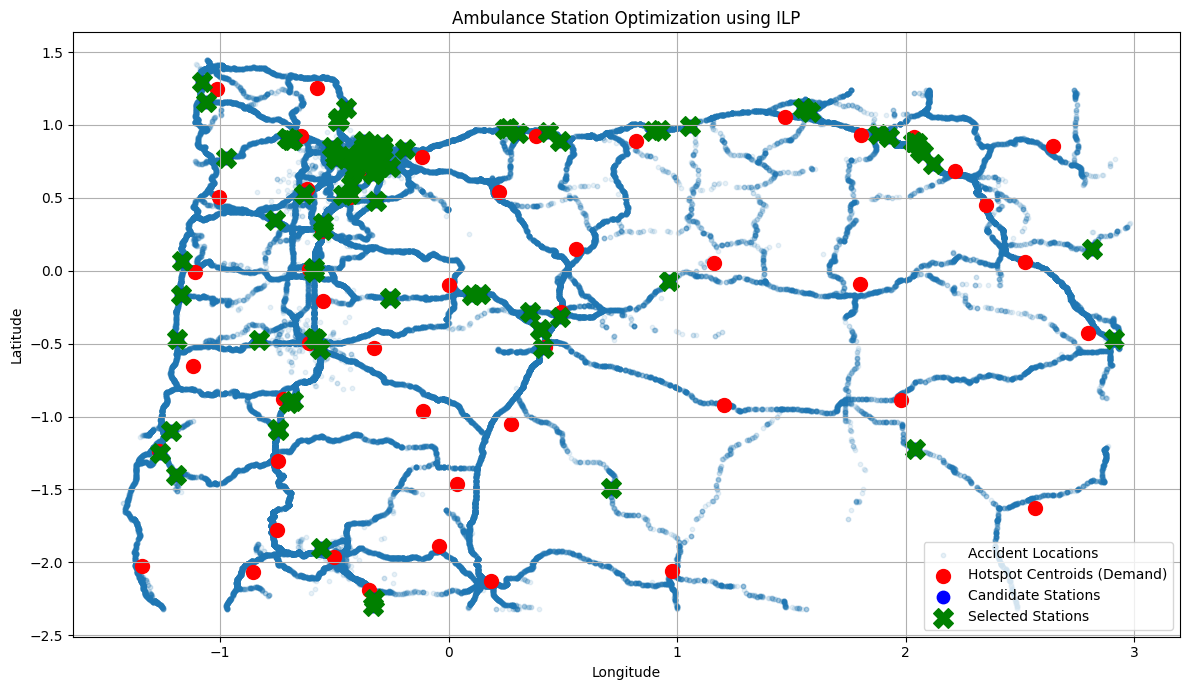

In [17]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from pulp import *
from geopy.distance import geodesic
import matplotlib.pyplot as plt

# Load accident location data
df = pd.read_excel("C:/Users/csk23/Documents/U.S/Northeastern/2nd SEM/DATA MINING/Preprocessed_US_Accidents.xlsx", usecols=["Start_Lat", "Start_Lng"])
df = df.dropna()

# Step 1: Cluster into demand zones
kmeans = KMeans(n_clusters=50, random_state=42)
df["Cluster"] = kmeans.fit_predict(df[["Start_Lat", "Start_Lng"]])
demand_points = kmeans.cluster_centers_

# Step 2: Select candidate station locations (sample real accident sites)
station_df = df.sample(n=100, random_state=1)
station_locations = station_df[["Start_Lat", "Start_Lng"]].values

# Step 3: Compute distance matrix (miles)
distance_matrix = [
    [geodesic(dp, sp).miles for sp in station_locations]
    for dp in demand_points
]

# Step 4: ILP model setup
model = LpProblem("Ambulance_Station_Allocation", LpMinimize)
x = LpVariable.dicts("Station", range(len(station_locations)), cat=LpBinary)
y = LpVariable.dicts("Coverage", (range(len(demand_points)), range(len(station_locations))), cat=LpBinary)

# Objective: minimize total distance
model += lpSum(distance_matrix[i][j] * y[i][j]
               for i in range(len(demand_points))
               for j in range(len(station_locations)))

# Constraints
for i in range(len(demand_points)):
    model += lpSum(y[i][j] for j in range(len(station_locations))) >= 1
    for j in range(len(station_locations)):
        model += y[i][j] <= x[j]

# Increase max number of stations allowed to 10 or more
model += lpSum(x[j] for j in range(len(station_locations))) <= 100

# Solve
model.solve()

# Step 5: Extract selected stations
selected_indices = [j for j in range(len(station_locations)) if x[j].varValue == 1]
selected_stations = [station_locations[j] for j in selected_indices]

# Step 6: Visualization
plt.figure(figsize=(12, 7))

# Plot all accident data
plt.scatter(df["Start_Lng"], df["Start_Lat"], alpha=0.1, label="Accident Locations", s=10)

# Plot demand zone centroids
plt.scatter(demand_points[:, 1], demand_points[:, 0], color="red", label="Hotspot Centroids (Demand)", s=100)

# Plot all candidate station locations
plt.scatter(station_locations[:, 1], station_locations[:, 0], color="blue", label="Candidate Stations", s=80)

# Highlight selected stations
if selected_stations:
    selected_stations = np.array(selected_stations)
    plt.scatter(selected_stations[:, 1], selected_stations[:, 0], color="green", label="Selected Stations", marker="X", s=200)

plt.title("Ambulance Station Optimization using ILP")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from time import sleep

# Assume selected_stations and selected_indices are already available
selected_station_coords = pd.DataFrame(selected_stations, columns=["Latitude", "Longitude"])
selected_station_coords["Station Index"] = selected_indices

# Setup geolocator
geolocator = Nominatim(user_agent="ambulance_locator")
geocode = RateLimiter(geolocator.reverse, min_delay_seconds=1)

# Extract city and county
cities = []
counties = []

for lat, lon in selected_station_coords[["Latitude", "Longitude"]].values:
    try:
        location = geolocator.reverse((lat, lon), timeout=10)
        address = location.raw.get("address", {})
        cities.append(address.get("city") or address.get("town") or address.get("village") or "Unknown")
        counties.append(address.get("county") or "Unknown")
    except:
        cities.append("Error")
        counties.append("Error")
    sleep(1)

# Append to dataframe
selected_station_coords["City"] = cities
selected_station_coords["County"] = counties

# Format the output table
final_station_table = selected_station_coords[["Station Index", "Latitude", "Longitude", "City", "County"]]

# Display the table
print("\nSelected Ambulance Stations with Location Details:")
print(final_station_table.to_string(index=False))

# Optionally save to Excel or CSV
# final_station_table.to_csv("Selected_Stations_With_City_County.csv", index=False)
# final_station_table.to_excel("Selected_Stations_With_City_County.xlsx", index=False)



Selected Ambulance Stations with Location Details:
 Station Index  Latitude  Longitude  City County
             0 -0.461949  -0.590545 Error  Error
             1  0.587851  -0.426708 Error  Error
             2 -1.397747  -1.192136 Error  Error
             3 -1.085145  -0.748144 Error  Error
             4  0.713930  -0.258050 Error  Error
             5 -0.319695   0.488780 Error  Error
             6  0.908360  -0.708172 Error  Error
             7  0.942736   0.301611 Error  Error
             8 -0.400551   0.399437 Error  Error
             9  0.324946  -0.548001 Error  Error
            10  1.118608   1.549446 Error  Error
            11  0.939263   1.878849 Error  Error
            12  0.752145  -0.308160 Error  Error
            13 -0.282122   0.357553 Error  Error
            14  1.048871  -0.479873 Error  Error
            15  0.680596  -0.324436 Error  Error
            16 -0.536553  -0.564461 Error  Error
            17  0.671681  -0.329062 Error  Error
            18  0

Classification Report:
               precision    recall  f1-score   support

          -2       0.50      0.24      0.32       262
           0       0.92      0.99      0.95     32544
           2       0.58      0.27      0.37      1960
           4       0.78      0.10      0.17      1166

    accuracy                           0.91     35932
   macro avg       0.69      0.40      0.45     35932
weighted avg       0.90      0.91      0.89     35932



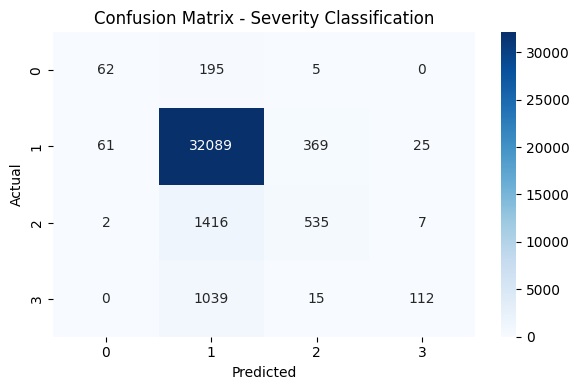


Forecasted Ambulance Demand by City:

City
Corbett         47
Springfield     12
Vida             9
Walterville      8
Portland         7
Estacada         6
Glide            4
Stayton          4
Wood Village     4
Eagle Creek      3
Name: Ambulance_Required, dtype: int64


In [ ]:
#Decision Tree
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load and sample dataset
df = pd.read_excel("C:/Users/csk23/Documents/U.S/Northeastern/2nd SEM/DATA MINING/Preprocessed_US_Accidents.xlsx")

# Step 1: Feature selection
features = [
    "Start_Lat", "Start_Lng", "Distance(mi)", "Temperature(F)", "Humidity(%)",
    "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", "City", "Weather_Condition",
    "Wind_Direction", "Sunrise_Sunset", "Crossing", "Junction", "Traffic_Signal"
]
df = df[features + ["Severity"]].dropna()

# Step 2: Convert Severity to integer
df["Severity"] = df["Severity"].astype(int)

# Step 3: One-hot encode categorical features
df_encoded = pd.get_dummies(df, columns=[
    "City", "Weather_Condition", "Wind_Direction", "Sunrise_Sunset"
], drop_first=True)

# Step 4: Split features and target
X = df_encoded.drop("Severity", axis=1)
y = df_encoded["Severity"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Train Decision Tree
model = DecisionTreeClassifier(max_depth=10, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Step 6: Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Severity Classification")
plt.tight_layout()
plt.show()

# Step 7: Forecast Ambulance Demand (Severity 3 or 4)
df_forecast = X_test.copy()
df_forecast["Predicted_Severity"] = y_pred
df_forecast["Ambulance_Required"] = df_forecast["Predicted_Severity"].apply(lambda x: 1 if x >= 3 else 0)

# Optional: Group demand forecast by city if available
# If 'City_' encoded columns exist, extract from one-hot encoding
city_cols = [col for col in df_forecast.columns if col.startswith("City_")]
if city_cols:
    df_forecast["City"] = df_forecast[city_cols].idxmax(axis=1).str.replace("City_", "")
    demand_by_city = df_forecast.groupby("City")["Ambulance_Required"].sum().sort_values(ascending=False)
    print("\nForecasted Ambulance Demand by City:\n")
    print(demand_by_city.head(10))


In [23]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.



Classification Report (Minor vs Major):

              precision    recall  f1-score   support

       Minor       0.92      0.78      0.85      1946
       Major       0.71      0.89      0.79      1179

    accuracy                           0.82      3125
   macro avg       0.82      0.83      0.82      3125
weighted avg       0.84      0.82      0.82      3125



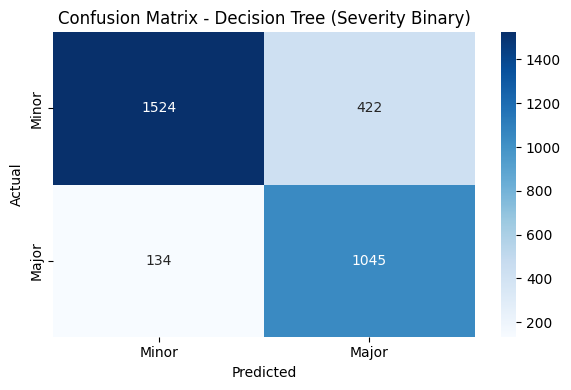

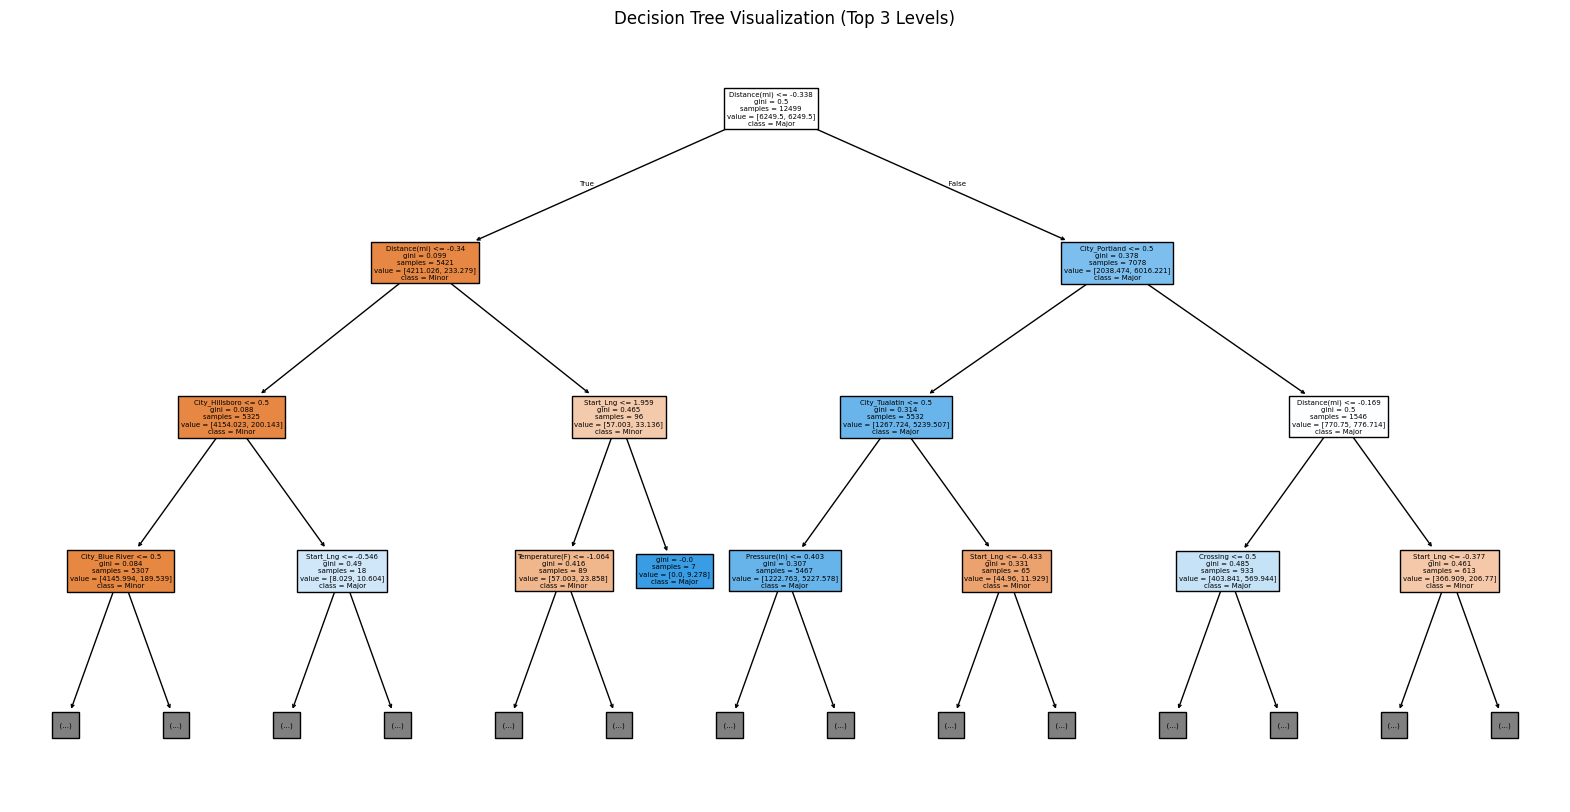

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the full dataset
df = pd.read_excel("C:/Users/csk23/Documents/U.S/Northeastern/2nd SEM/DATA MINING/Preprocessed_US_Accidents.xlsx")  # Update with your correct file path

# Step 2: Convert Severity into Binary Class (Minor: 1/2, Major: 3/4)
df = df[df["Severity"] >= 0]
df["Severity_Binary"] = df["Severity"].apply(lambda x: 1 if x >= 3 else 0)

# Step 3: Select useful features
features = [
    "Start_Lat", "Start_Lng", "Distance(mi)", "Temperature(F)", "Humidity(%)",
    "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", "City",
    "Weather_Condition", "Wind_Direction", "Sunrise_Sunset",
    "Crossing", "Junction", "Traffic_Signal"
]

df = df[features + ["Severity_Binary"]].dropna()

# Step 4: One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=[
    "City", "Weather_Condition", "Wind_Direction", "Sunrise_Sunset"
], drop_first=True)

# Step 5: Train-test split
X = df_encoded.drop("Severity_Binary", axis=1)
y = df_encoded["Severity_Binary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Step 6: Compute class weights
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), weights))

# Step 7: Train Decision Tree
model = DecisionTreeClassifier(class_weight=class_weights, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Step 8: Predict and evaluate
y_pred = model.predict(X_test)

print("\nClassification Report (Minor vs Major):\n")
print(classification_report(y_test, y_pred, target_names=["Minor", "Major"]))

# Step 9: Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Minor", "Major"], yticklabels=["Minor", "Major"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Decision Tree (Severity Binary)")
plt.tight_layout()
plt.show()

# Step 10: Optional - Visualize the tree
plt.figure(figsize=(20, 10))
plot_tree(model, filled=True, feature_names=X.columns, class_names=["Minor", "Major"], max_depth=3)
plt.title("Decision Tree Visualization (Top 3 Levels)")
plt.show()


Accuracy:  0.8221
Precision: 0.7123
Recall:    0.8863
F1 Score:  0.7899

Confusion Matrix:
 [[1524  422]
 [ 134 1045]]


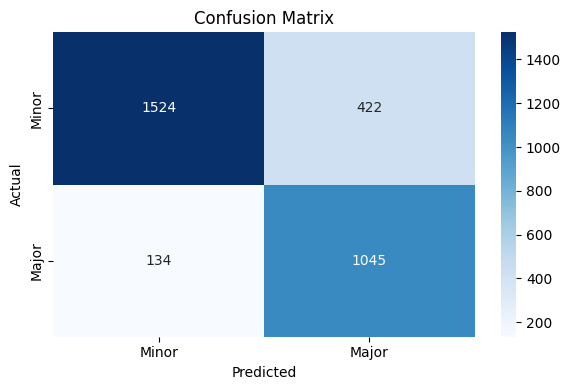

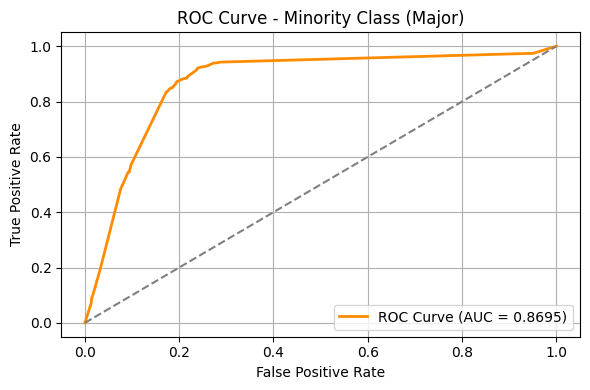

In [25]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns

# y_test: true labels
# y_pred: predicted labels
# model.predict_proba(X_test): predicted probabilities

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Precision, Recall, F1 (with class 1 as the positive class)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["Minor", "Major"], yticklabels=["Minor", "Major"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ROC Curve
y_prob = model.predict_proba(X_test)[:, 1]  # Probability for class 1
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Minority Class (Major)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
pip install pandas matplotlib statsmodels openpyxl

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   -------------------------- ------------- 6.6/9.8 MB 33.7 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 27.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


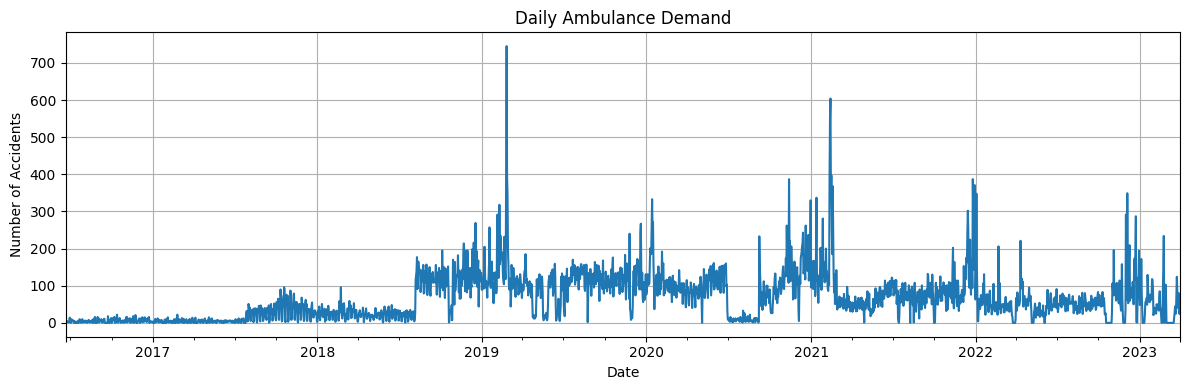

Root Mean Squared Error (RMSE): 55.99


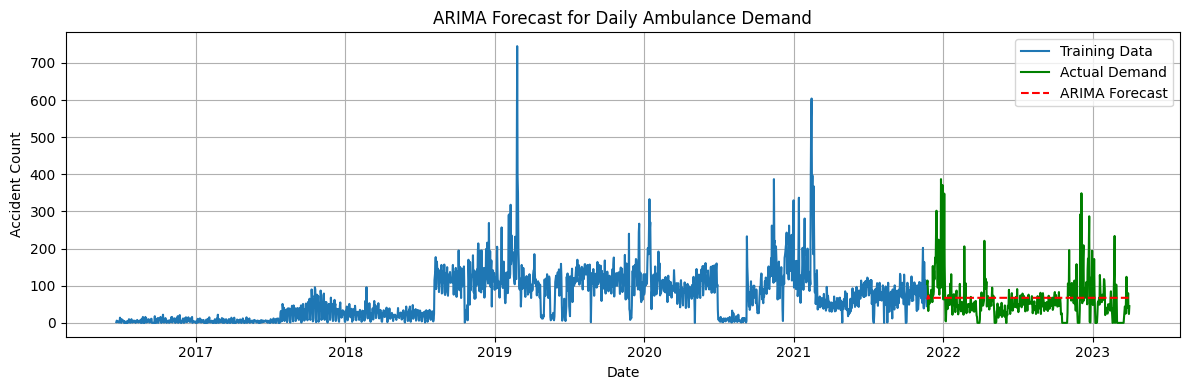

In [ ]:
#ARIMA
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Load the full dataset
df = pd.read_excel("C:/Users/csk23/Documents/U.S/Northeastern/2nd SEM/DATA MINING/Preprocessed_US_Accidents.xlsx")  # Adjust path if needed

# Step 2: Convert 'Start_Time' to datetime (handles nanoseconds)
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')

# Drop rows where datetime couldn't be parsed
df = df.dropna(subset=['Start_Time'])

# Step 3: Set datetime as index and resample by day
df.set_index('Start_Time', inplace=True)
daily_demand = df.resample('D').size().rename("Accident_Count")

# Step 4: Plot original demand
plt.figure(figsize=(12, 4))
daily_demand.plot(title="Daily Ambulance Demand")
plt.xlabel("Date")
plt.ylabel("Number of Accidents")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 5: Split data into training and testing
train_size = int(len(daily_demand) * 0.8)
train, test = daily_demand[:train_size], daily_demand[train_size:]

# Step 6: Fit ARIMA model
model = ARIMA(train, order=(5, 1, 0))  # You can tune (p,d,q)
fitted_model = model.fit()

# Step 7: Forecast future demand
forecast = fitted_model.forecast(steps=len(test))

# Step 8: Evaluation
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Step 9: Plot forecast vs actual
plt.figure(figsize=(12, 4))
plt.plot(train.index, train, label="Training Data")
plt.plot(test.index, test, label="Actual Demand", color="green")
plt.plot(test.index, forecast, label="ARIMA Forecast", color="red", linestyle="--")
plt.title("ARIMA Forecast for Daily Ambulance Demand")
plt.xlabel("Date")
plt.ylabel("Accident Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
